In [1]:
""" Check if linear trend is implemented correctly.
-------------------------------------------------------------------------------

Author: Rutger Hofste
Date: 20180621
Kernel: python35
Docker: rutgerhofste/gisdocker:ubuntu16.04

Args:
    TESTING (Boolean) : Toggle testing case.
    SCRIPT_NAME (string) : Script name.
    OUTPUT_VERSION (integer) : output version.
    DATABASE_ENDPOINT (string) : RDS or postGreSQL endpoint.
    DATABASE_NAME (string) : Database name.
    TABLE_NAME_AREA_30SPFAF06 (string) : Table name used for areas. Must exist
        on same database as used in rest of script.
    S3_INPUT_PATH_RIVERDISCHARGE (string) : AWS S3 input path for 
        riverdischarge.    
    S3_INPUT_PATH_DEMAND (string) : AWS S3 input path for 
        demand.     

"""


OVERWRITE_OUTPUT = 1
SCRIPT_NAME = 'Y2018M06D21_RH_QA_Linear_Trend_PostGIS_V01'
OUTPUT_VERSION = 1

DATABASE_ENDPOINT = "aqueduct30v05.cgpnumwmfcqc.eu-central-1.rds.amazonaws.com"
DATABASE_NAME = "database01"

INPUT_TABLE_NAME_RAW = 'y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02'
INPUT_TABLE_NAME_MA = 'y2018m06d01_rh_moving_average_postgis_30spfaf06_v01_v03'
OUTPUT_TABLE_NAME = SCRIPT_NAME.lower() + "_v{:02.0f}".format(OUTPUT_VERSION)
OUTPUT_SCHEMA_NAME = "test"

TEST_BASIN_PFAF_ID = 231607
MONTH = 5
TEMPORAL_RESOLUTION = "month"



print("Input Table RAW: " , INPUT_TABLE_NAME_RAW, 
      "\nInput Table MA: ", INPUT_TABLE_NAME_MA,
      "\nOutput Table: " , OUTPUT_TABLE_NAME)

Input Table RAW:  y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 
Input Table MA:  y2018m06d01_rh_moving_average_postgis_30spfaf06_v01_v03 
Output Table:  y2018m06d21_rh_qa_linear_trend_postgis_v01_v01


In [2]:
import time, datetime, sys
dateString = time.strftime("Y%YM%mD%d")
timeString = time.strftime("UTC %H:%M")
start = datetime.datetime.now()
print(dateString,timeString)
sys.version

Y2018M06D21 UTC 15:20


'3.5.4 |Anaconda, Inc.| (default, Nov 20 2017, 18:44:38) \n[GCC 7.2.0]'

In [3]:
# imports
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import aqueduct3
from datetime import timedelta
from sqlalchemy import *
pd.set_option('display.max_columns', 500)

from sklearn import linear_model
%matplotlib inline

In [4]:
F = open("/.password","r")
password = F.read().splitlines()[0]
F.close()

engine = create_engine("postgresql://rutgerhofste:{}@{}:5432/{}".format(password,DATABASE_ENDPOINT,DATABASE_NAME))
connection = engine.connect()

# Raw Values

In [5]:
sql_raw = ("SELECT * FROM {} "
           "WHERE pfafid_30spfaf06 = {} AND "
           "month = {} AND "
           "temporal_resolution = '{}'".format(INPUT_TABLE_NAME_RAW,TEST_BASIN_PFAF_ID,MONTH,TEMPORAL_RESOLUTION))

In [6]:
print(sql_raw)

SELECT * FROM y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 WHERE pfafid_30spfaf06 = 231607 AND month = 5 AND temporal_resolution = 'month'


In [7]:
df_raw = pd.read_sql(sql_raw,connection)

In [8]:
df_raw.head()

,pfafid_30spfaf06,area_count_30spfaf06,area_m2_30spfaf06,month,pdomwn_count_30spfaf06,pdomwn_m_30spfaf06,pdomww_count_30spfaf06,pdomww_m_30spfaf06,pindwn_count_30spfaf06,pindwn_m_30spfaf06,pindww_count_30spfaf06,pindww_m_30spfaf06,pirrwn_count_30spfaf06,pirrwn_m_30spfaf06,pirrww_count_30spfaf06,pirrww_m_30spfaf06,plivwn_count_30spfaf06,plivwn_m_30spfaf06,plivww_count_30spfaf06,plivww_m_30spfaf06,riverdischarge_count_30spfaf06,riverdischarge_m_30spfaf06,temporal_resolution,year,input_file_name,datetime_stamp,ptotwn_m_30spfaf06,ptotww_m_30spfaf06
0,231607,24502,1.613991e+10,5,24502,0.000201,24502,0.000280,24502,0.000401,24502,0.001338,24502,0.000242,24502,0.000445,24502,0.000002,24502,0.000002,24502.0,0.040631,month,1978,global_historical_merged_month_m_30sPfaf06_196...,2018-06-04 16:06:51.778354,0.000846,0.002065
1,231607,24502,1.613991e+10,5,24502,0.000370,24502,0.000560,24502,0.000450,24502,0.002249,24502,0.000916,24502,0.001681,24502,0.000003,24502,0.000003,24502.0,0.027207,month,2003,global_historical_merged_month_m_30sPfaf06_196...,2018-06-04 16:09:13.813702,0.001738,0.004493
2,231607,24502,1.613991e+10,5,24502,0.000216,24502,0.000304,24502,0.000423,24502,0.001409,24502,0.000694,24502,0.001273,24502,0.000002,24502,0.000002,24502.0,0.012177,month,1982,global_historical_merged_month_m_30sPfaf06_196...,2018-06-04 16:09:44.234319,0.001335,0.002988
3,231607,24502,1.613991e+10,5,24502,0.000209,24502,0.000294,24502,0.000406,24502,0.001354,24502,0.000179,24502,0.000328,24502,0.000002,24502,0.000002,24502.0,0.026978,month,1984,global_historical_merged_month_m_30sPfaf06_196...,2018-06-04 16:09:54.369852,0.000796,0.001979
4,231607,24502,1.613991e+10,5,24502,0.000320,24502,0.000485,24502,0.000408,24502,0.002042,24502,0.001362,24502,0.002500,24502,0.000003,24502,0.000003,24502.0,0.006945,month,1999,global_historical_merged_month_m_30sPfaf06_196...,2018-06-04 16:10:14.544299,0.002094,0.005029


In [9]:
def simplify_df_raw(df):
    df_out = df[["year","ptotww_m_30spfaf06","ptotwn_m_30spfaf06","riverdischarge_m_30spfaf06"]]
    return df_out

In [10]:
df_raw = simplify_df_raw(df_raw)

In [11]:
df_raw.head()

,year,ptotww_m_30spfaf06,ptotwn_m_30spfaf06,riverdischarge_m_30spfaf06
0,1978,0.002065,0.000846,0.040631
1,2003,0.004493,0.001738,0.027207
2,1982,0.002988,0.001335,0.012177
3,1984,0.001979,0.000796,0.026978
4,1999,0.005029,0.002094,0.006945


In [12]:
df_raw = df_raw.sort_values(by=["year"])

(0.0012804728147330999, 0.0079848467353448895)

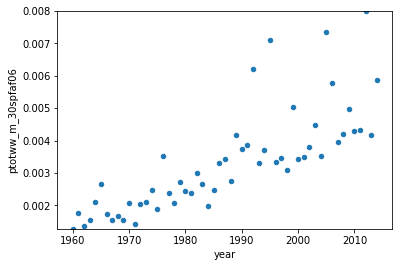

In [13]:
ax1 = df_raw.plot.scatter("year","ptotww_m_30spfaf06")
ax1.set_ylim(df_raw["ptotww_m_30spfaf06"].min(),df_raw["ptotww_m_30spfaf06"].max())

(0.0038965675346747902, 0.047979822017249797)

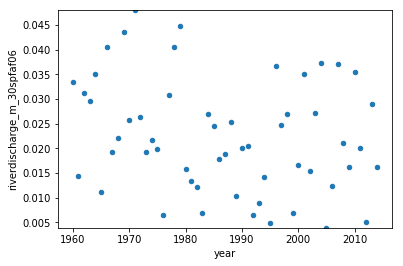

In [14]:
ax1 = df_raw.plot.scatter("year","riverdischarge_m_30spfaf06")
ax1.set_ylim(df_raw["riverdischarge_m_30spfaf06"].min(),df_raw["riverdischarge_m_30spfaf06"].max())

# Moving Average

In [15]:
sql_ma = ("SELECT * FROM {} "
           "WHERE pfafid_30spfaf06 = {} AND "
           "month = {} AND "
           "temporal_resolution = '{}'".format(INPUT_TABLE_NAME_MA,TEST_BASIN_PFAF_ID,MONTH,TEMPORAL_RESOLUTION))

In [16]:
print(sql_ma)

SELECT * FROM y2018m06d01_rh_moving_average_postgis_30spfaf06_v01_v03 WHERE pfafid_30spfaf06 = 231607 AND month = 5 AND temporal_resolution = 'month'


In [17]:
df_ma = pd.read_sql(sql_ma,connection)

In [18]:
df_ma.head()

,pfafid_30spfaf06,temporal_resolution,year,month,area_m2_30spfaf06,area_count_30spfaf06,ma10_pdomww_m_30spfaf06,ma10_pdomwn_m_30spfaf06,ma10_pindww_m_30spfaf06,ma10_pindwn_m_30spfaf06,ma10_pirrww_m_30spfaf06,ma10_pirrwn_m_30spfaf06,ma10_plivww_m_30spfaf06,ma10_plivwn_m_30spfaf06,ma10_ptotww_m_30spfaf06,ma10_ptotwn_m_30spfaf06,ma10_riverdischarge_m_30spfaf06
0,231607,month,1960,5,1.613991e+10,24502,0.000114,0.000082,0.000620,0.000186,0.000545,0.000297,0.000002,0.000002,0.001280,0.000567,0.033538
1,231607,month,1961,5,1.613991e+10,24502,0.000117,0.000084,0.000633,0.000190,0.000772,0.000421,0.000002,0.000002,0.001524,0.000696,0.023935
2,231607,month,1962,5,1.613991e+10,24502,0.000120,0.000084,0.000648,0.000172,0.000699,0.000381,0.000002,0.000002,0.001469,0.000639,0.026336
3,231607,month,1963,5,1.613991e+10,24502,0.000124,0.000086,0.000664,0.000164,0.000703,0.000383,0.000002,0.000002,0.001492,0.000635,0.027164
4,231607,month,1964,5,1.613991e+10,24502,0.000127,0.000088,0.000679,0.000161,0.000810,0.000441,0.000002,0.000002,0.001618,0.000692,0.028746


In [19]:
def simplify_df_ma(df):
    df_out = df[["year","ma10_ptotww_m_30spfaf06","ma10_ptotwn_m_30spfaf06","ma10_riverdischarge_m_30spfaf06"]]
    return df_out

In [20]:
df_ma = simplify_df_ma(df_ma)

In [21]:
df_ma.head()

,year,ma10_ptotww_m_30spfaf06,ma10_ptotwn_m_30spfaf06,ma10_riverdischarge_m_30spfaf06
0,1960,0.001280,0.000567,0.033538
1,1961,0.001524,0.000696,0.023935
2,1962,0.001469,0.000639,0.026336
3,1963,0.001492,0.000635,0.027164
4,1964,0.001618,0.000692,0.028746


In [22]:
df_ma = df_ma.sort_values(by=["year"])

(0.0012804728147330999, 0.0052950611997794796)

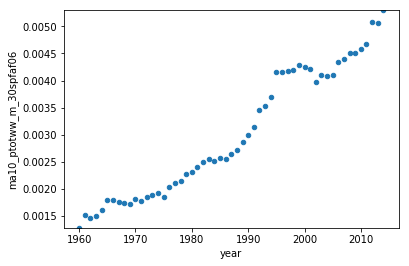

In [23]:
ax1 = df_ma.plot.scatter("year","ma10_ptotww_m_30spfaf06")
ax1.set_ylim(df_ma["ma10_ptotww_m_30spfaf06"].min(),df_ma["ma10_ptotww_m_30spfaf06"].max())

(0.014742369294132701, 0.033537676399587699)

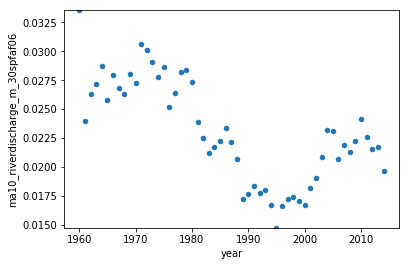

In [24]:
ax1 = df_ma.plot.scatter("year","ma10_riverdischarge_m_30spfaf06")
ax1.set_ylim(df_ma["ma10_riverdischarge_m_30spfaf06"].min(),df_ma["ma10_riverdischarge_m_30spfaf06"].max())

# Combined

In [25]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool

In [26]:
output_notebook()

Loading BokehJS ...

In [27]:
p = figure(width=800, height=500)
p.line(x = df_raw["year"], y = df_raw['ptotww_m_30spfaf06'],line_color="#349e17",legend="ptotww_m_30spfaf06")
p.line(x = df_raw["year"], y = df_raw['ptotwn_m_30spfaf06'],line_color="#af4c1d",legend="ptotwn_m_30spfaf06")
p.line(x = df_raw["year"], y = df_raw['riverdischarge_m_30spfaf06'],line_color="#003baa",legend="riverdischarge_m_30spfaf06")
p.line(x = df_ma["year"], y = df_ma['ma10_ptotww_m_30spfaf06'],line_color="#3fea10",legend="ma10_ptotww_m_30spfaf06")
p.line(x = df_ma["year"], y = df_ma['ma10_ptotwn_m_30spfaf06'],line_color="#f4570e",legend="ma10_ptotwn_m_30spfaf06")
p.line(x = df_ma["year"], y = df_ma['ma10_riverdischarge_m_30spfaf06'],line_color="#01a8b7",legend="ma10_riverdischarge_m_30spfaf06")
p.legend.location = "top_left"
p.legend.click_policy="hide"

hover = HoverTool(tooltips = [('year', '@x'),
                             ('value',  '@y')])

p.add_tools(hover)
show(p)

# Regression

there are multiple options for linear regression. 

1. Withdrawal and river discharge separately: Use a moving window of 10 years, perform ols regression and determine the final year for each window.
    Probably requires some thresholds for basins with a small number of valid years. (e.g. capped at max value, and minimum 0?)
1. Use a linear trend for demand and a moving average for riverdischarge






In [42]:
sql_reg = ("SELECT year,month,pfafid_30spfaf06, temporal_resolution,ptotww_m_30spfaf06 "
"FROM y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 " 
"WHERE pfafid_30spfaf06 = 231607 "
"AND month = 5")

In [43]:
df_reg = pd.read_sql(sql_reg,connection)

In [46]:
df_reg = df_reg.sort_values(by=["year"])

In [47]:
df_reg.head()

,year,month,pfafid_30spfaf06,temporal_resolution,ptotww_m_30spfaf06
8,1960,5,231607,month,0.001280
49,1961,5,231607,month,0.001767
53,1962,5,231607,month,0.001359
51,1963,5,231607,month,0.001563
7,1964,5,231607,month,0.002121


In [38]:
lm = linear_model.LinearRegression()

In [52]:
# Fit line for year 1973 - 1982 (10 years)
df_reg_selection = df_reg[(df_reg["year"] >= 1973) & (df_reg["year"] <= 1982)]

In [54]:
df_reg_selection

,year,month,pfafid_30spfaf06,temporal_resolution,ptotww_m_30spfaf06
38,1973,5,231607,month,0.002092
10,1974,5,231607,month,0.002490
14,1975,5,231607,month,0.001879
52,1976,5,231607,month,0.003525
24,1977,5,231607,month,0.002373
0,1978,5,231607,month,0.002065
25,1979,5,231607,month,0.002719
37,1980,5,231607,month,0.002458
28,1981,5,231607,month,0.002397
2,1982,5,231607,month,0.002988


In [70]:
import os

In [73]:
print(os.getcwd())

/volumes/repos/Aqueduct30Docker/notebooks/qa


In [69]:
df_reg_selection.to_csv("temp.csv")

In [59]:
# fit linear model. 

In [64]:
x = pd.DataFrame(df_reg_selection["year"])
target = pd.DataFrame(df_reg_selection["ptotww_m_30spfaf06"])

In [65]:
lm.fit(x,target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [90]:
df_lm = pd.DataFrame()

In [97]:
coef = lm.coef_[0][0]

In [98]:
intercept = lm.intercept_[0]

In [99]:
# projected value for 1982
y_p = 1982*coef + intercept

In [100]:
print(y_p,coef,intercept)

0.00270541029818 4.59737549865e-05 -0.088414572085


In [101]:
# check if I can accomplish the same using SQL
SELECT year,month,pfafid_30spfaf06, temporal_resolution,ptotww_m_30spfaf06,
    regr_slope(ptotww_m_30spfaf06,year) 
        OVER (PARTITION BY pfafid_30spfaf06, month, temporal_resolution ORDER BY year ROWS BETWEEN 9 PRECEDING AND CURRENT ROW) AS slope
FROM y2018m05d29_rh_total_demand_postgis_30spfaf06_v01_v02 
WHERE year > 1970 AND
year < 1983 AND
year > 1972 AND
month = 5 AND
temporal_resolution = 'month'AND
pfafid_30spfaf06 = 231607

SyntaxError: EOL while scanning string literal (<ipython-input-101-f77ace0ae007>, line 9)